In [1]:
#import modules
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import FCPython 
from mplsoccer import Pitch, VerticalPitch
from mplsoccer.utils import FontManager
from highlight_text import HighlightText, ax_text, fig_text

#stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load saved csv
shots_model = pd.read_csv('../Datasets/shots_model.csv')
all_shots_model = pd.read_csv('../Datasets/all_shots_model.csv')

In [3]:
shots_model.describe()

,matchID,Goal,X,Y,C,Angle,Distance
count,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000
mean,193.355386,0.097475,14.730455,50.589183,9.663568,0.455394,17.383690
std,110.972230,0.296620,7.387397,11.913849,6.992290,0.267381,7.570433
min,1.000000,0.000000,0.300000,1.300000,0.000000,0.004663,1.523327
25%,98.000000,0.000000,9.000000,42.500000,3.700000,0.272737,11.325640
50%,193.000000,0.000000,13.300000,50.400000,8.400000,0.364349,16.297292
75%,294.000000,0.000000,20.700000,59.200000,14.900000,0.560177,23.709030
max,380.000000,1.000000,70.100000,93.800000,48.700000,2.807597,73.611457


In [4]:
# Detect ridiculous angle-based shots outliers
shots_model.Angle.min()
outlier = shots_model.loc[(shots_model['Goal'] == 1) & (shots_model['Angle'] < 0.005)]
outlier

,matchID,Goal,X,Y,C,Angle,Distance
8690,366.0,1,0.6,1.3,48.7,0.004663,31.661269


In [5]:
# Drop angle outlier row
shots_model = shots_model.drop(outlier.index)

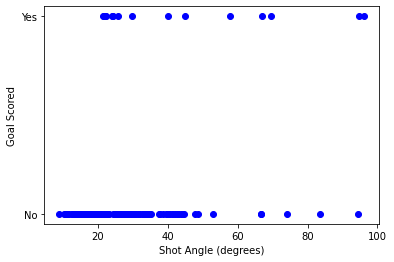

In [6]:
#Get first 200 shots
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='blue')
ax.set_ylabel('Goal Scored')
ax.set_xlabel("Shot Angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()
fig.savefig('xG_Output/Angle_Classification.png', bbox_inches="tight") 

C:\Users\User\anaconda3\envs\mplsoccer\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


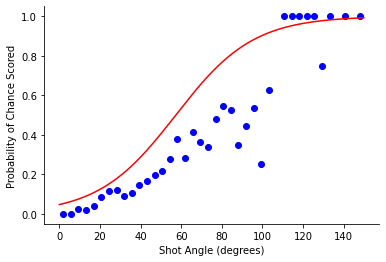

In [7]:
# All shots that result in goals only
goals_only = shots_model.loc[shots_model['Goal'] == 1]

#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='blue')
ax.set_ylabel('Probability of Chance Scored')
ax.set_xlabel("Shot Angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='red')
plt.show()

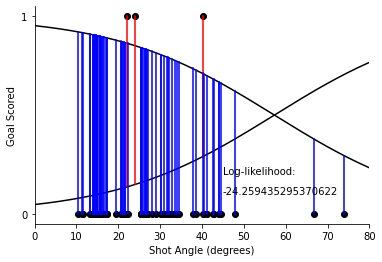

In [8]:
# likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_80=shots_model.iloc[:80]
fig,ax=plt.subplots(num=1)
ax.plot(shots_80['Angle']*180/np.pi, shots_80['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_80.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal Scored')
ax.set_xlabel("Shot Angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('xG_Output/Likelihood.png', dpi=None, bbox_inches="tight")   
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 9068
Model:                            GLM   Df Residuals:                     9066
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2591.9
Date:                Wed, 13 Apr 2022   Deviance:                       5183.9
Time:                        14:48:25   Pearson chi2:                 8.68e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6383      0.076    -48.015      0.0

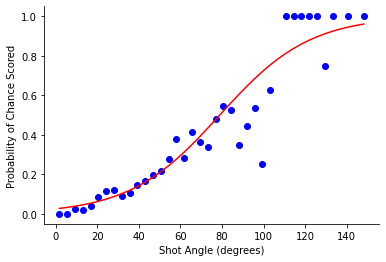

In [9]:
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
#b = [3,-3]

xGprob=1/(1+np.exp(-b[0]-b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='blue')
ax.plot(midangle, xGprob, linestyle='solid', color='red')
ax.set_ylabel('Probability of Chance Scored')
ax.set_xlabel("Shot Angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Save figure
fig.savefig('xG_Output/xGBasedonAngle.png', bbox_inches="tight")  

C:\Users\User\anaconda3\envs\mplsoccer\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 9068
Model:                            GLM   Df Residuals:                     9066
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2605.3
Date:                Wed, 13 Apr 2022   Deviance:                       5210.7
Time:                        14:48:25   Pearson chi2:                 9.55e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2456      0.087     -2.811      0.0

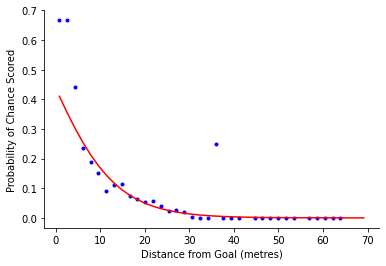

In [10]:
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='blue')
ax.set_ylabel('Probability of Chance Scored')
ax.set_xlabel("Distance from Goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(-b[0]-b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='red')
plt.show()

# Save figure
fig.savefig('xG_Output/xGBasedonDistance.png', bbox_inches="tight")  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 9068
Model:                            GLM   Df Residuals:                     9065
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2596.7
Date:                Wed, 13 Apr 2022   Deviance:                       5193.5
Time:                        14:48:26   Pearson chi2:                 9.17e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2553      0.130      1.958      0.0

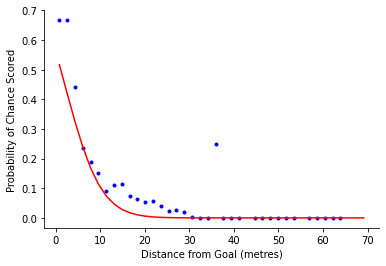

In [11]:
# Add distance(squared)
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(-b[0]-b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='blue')
ax.set_ylabel('Probability of Chance Scored')
ax.set_xlabel("Distance from Goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='red')
plt.show()

In [12]:
#Adding even more variables to the model.
squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)


# Fitting Goal Probability Model (xG)
# Taking Angle and Distance into account
model_variables = ['Angle','Distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=-(test_model.params)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 9068
Model:                            GLM   Df Residuals:                     9065
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2567.0
Date:                Wed, 13 Apr 2022   Deviance:                       5134.0
Time:                        14:48:26   Pearson chi2:                 8.87e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0827      0.230     -9.062      0.0

In [13]:
#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)
goals_shots_model = shots_model.loc[shots_model['Goal'] == 1]
goals_shots_model

,matchID,Goal,X,Y,C,Angle,Distance,xG,D2,X2,C2,AX
16,1.0,1,16.0,54.0,4.0,0.419693,17.000000,0.072146,289.000000,256.00,16.00,6.715093
59,2.0,1,17.8,48.8,1.2,0.386127,18.706269,0.061854,349.924500,316.84,1.44,6.873067
63,3.0,1,8.0,56.1,6.1,0.700780,9.288769,0.166922,86.281225,64.00,37.21,5.606242
79,4.0,1,2.6,47.0,3.0,1.677487,3.354907,0.575070,11.255400,6.76,9.00,4.361467
85,4.0,1,5.1,48.2,1.8,1.169144,5.481325,0.347959,30.044925,26.01,3.24,5.962632
...,...,...,...,...,...,...,...,...,...,...,...,...
9029,379.0,1,7.4,60.2,10.2,0.558936,10.214196,0.131333,104.329800,54.76,104.04,4.136123
9030,379.0,1,10.0,43.1,6.9,0.581346,11.417759,0.126314,130.365225,100.00,47.61,5.813458
9046,379.0,1,8.5,63.3,13.3,0.433903,12.425444,0.097114,154.391650,72.25,176.89,3.688175
9050,380.0,1,7.3,49.0,1.0,0.886427,7.692511,0.229071,59.174725,53.29,1.00,6.470917


In [14]:
shots_model

,matchID,Goal,X,Y,C,Angle,Distance,xG,D2,X2,C2,AX
0,1.0,0,14.0,73.1,23.1,0.246227,21.012859,0.043562,441.540225,196.00,533.61,3.447172
1,1.0,0,22.2,34.9,15.1,0.265987,25.292100,0.034185,639.690325,492.84,228.01,5.904907
2,1.0,0,22.9,65.1,15.1,0.260201,25.971066,0.032450,674.496250,524.41,228.01,5.958606
3,1.0,0,26.8,60.3,10.3,0.245165,28.925467,0.026244,836.682625,718.24,106.09,6.570423
4,1.0,0,14.8,49.3,0.7,0.462249,15.546660,0.083787,241.698625,219.04,0.49,6.841293
...,...,...,...,...,...,...,...,...,...,...,...,...
9064,380.0,0,26.5,56.5,6.5,0.255836,28.143938,0.028046,792.081250,702.25,42.25,6.779652
9065,380.0,0,22.8,60.8,10.8,0.280179,24.948026,0.035696,622.404000,519.84,116.64,6.388073
9066,380.0,0,13.6,45.2,4.8,0.481074,14.616867,0.091019,213.652800,184.96,23.04,6.542607
9067,380.0,0,26.0,52.2,2.2,0.265834,27.337427,0.029985,747.334900,676.00,4.84,6.911695


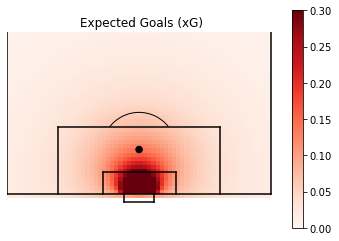

In [15]:
# xG Pitch Map
probgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        probgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(probgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Expected Goals (xG)')
plt.xlim((0,66))
plt.ylim((-3,40))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('xG_Output/xG_Probability.png', bbox_inches="tight") 

In [16]:
# Calculate xG for all shots
xG=all_shots_model.apply(calculate_xG, axis=1) 
xg_all_shots_model = all_shots_model.assign(xG=xG)
xg_all_shots_model

,matchID,teamID,Goal,X,Y,C,Angle,Distance,xG
0,1.0,Burnley,0,14.0,73.1,23.1,0.246227,21.012859,0.043562
1,1.0,Burnley,0,22.2,34.9,15.1,0.265987,25.292100,0.034185
2,1.0,Burnley,0,22.9,65.1,15.1,0.260201,25.971066,0.032450
3,1.0,Burnley,0,26.8,60.3,10.3,0.245165,28.925467,0.026244
4,1.0,Manchester United,0,14.8,49.3,0.7,0.462249,15.546660,0.083787
...,...,...,...,...,...,...,...,...,...
9189,380.0,Wolves,0,26.5,56.5,6.5,0.255836,28.143938,0.028046
9190,380.0,Manchester United,0,22.8,60.8,10.8,0.280179,24.948026,0.035696
9191,380.0,Wolves,0,13.6,45.2,4.8,0.481074,14.616867,0.091019
9192,380.0,Wolves,0,26.0,52.2,2.2,0.265834,27.337427,0.029985


In [17]:
# Observe xG of shots that resulted in a Goal
goals_all_shots_model = xg_all_shots_model.loc[xg_all_shots_model['Goal'] == 1]
goals_all_shots_model

,matchID,teamID,Goal,X,Y,C,Angle,Distance,xG
16,1.0,Manchester United,1,16.0,54.0,4.0,0.419693,17.000000,0.072146
59,2.0,Manchester City,1,17.8,48.8,1.2,0.386127,18.706269,0.061854
62,2.0,Manchester City,1,11.5,50.0,0.0,0.588607,12.075000,0.122807
64,3.0,Crystal Palace,1,8.0,56.1,6.1,0.700780,9.288769,0.166922
80,4.0,Arsenal,1,2.6,47.0,3.0,1.677487,3.354907,0.575070
...,...,...,...,...,...,...,...,...,...
9154,379.0,West Ham United,1,10.0,43.1,6.9,0.581346,11.417759,0.126314
9170,379.0,West Ham United,1,8.5,63.3,13.3,0.433903,12.425444,0.097114
9174,380.0,Manchester United,1,7.3,49.0,1.0,0.886427,7.692511,0.229071
9178,380.0,Wolves,1,6.8,45.5,4.5,0.847563,7.715907,0.218315


In [18]:
xg_all_shots_model.to_csv('../Datasets/xg_all_shots_model.csv', index=False)

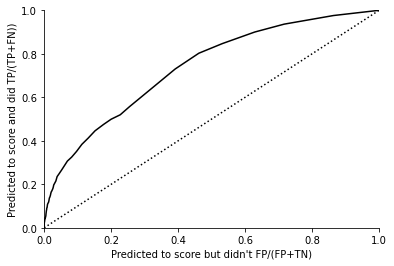

In [19]:
# Evaluation
null_model = smf.glm(formula="Goal ~ 1 ", data=shots_model, 
                           family=sm.families.Binomial()).fit()
1-test_model.llf/null_model.llf

#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)


for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shots_model.iterrows():
        if (shot['Goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1
     
# Plot ROC Curve
fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)           
fig.savefig('xG_Output/ROC_' + model  + '.png', dpi=None, bbox_inches="tight")  